In [698]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import io
import math
from sympy.solvers import solve
from sympy import Symbol
z = Symbol('x')

In [728]:
class maketrial(dict): #create trials class to easily store trials without passing around d
    def add(self,attr,val):
        self[attr] = val

class maketrials(dict):
    def __init__(self, filename):
        initimport = pd.read_csv(filename,header = None)
        initimport.columns = ['x','y']
        nums = list(initimport.loc[initimport['x'] == 0].index)
        nums.insert(0,0)
        fullrange = [t[1] for t in zip(nums, nums[1:]) if t[0]+1 != t[1]]
        fullrange.insert(0,0)
        fullranges = [list(t) for t in zip(fullrange, fullrange[1:])]
        #print(fullranges)
        ranges = [list(t) for t in zip(nums, nums[1:]) if t[0]+1 != t[1]]
        #print(ranges)
        ite = 0
        for i in range(len(ranges)):
            rangeiq = ranges[i]
            fullrangeiq = fullranges[i]
            ite += 1
            nozero = initimport.iloc[rangeiq[0]+1:rangeiq[1]-1]
            zero = initimport.iloc[fullrangeiq[0]+1:fullrangeiq[1]-1]
            self[f"{ite}"] = maketrial()
            self[f"{ite}"].add('raw',nozero)
            self[f"{ite}"].add('rawz',zero)
#         for rangeiq in ranges:
#             ite += 1
#             toplt = initimport.iloc[rangeiq[0]+1:rangeiq[1]]
#             self[f"{ite}"] = maketrial(toplt)
    def plot(self):
        for item in self.keys():
            toplt = self[item]['raw']
            plt.plot(toplt['x'],toplt['y'])
            axes = plt.gca()
            axes.set_xlim([0,1500])
            axes.set_ylim([0,500])
        plt.show()
    def evalrules(self,filename):
       
        with open(filename, 'r') as stream:
            data_loaded = yaml.safe_load(stream)
        indicators = pd.DataFrame(data_loaded['rules']).T
        
        for item in self.keys():

            trial = self[item]
            #print(trial['x'])
            leng = len(indicators)
            initalarray = np.zeros(leng)
            for i in range(leng):
                #print(i,type(i))
                func = eval(indicators.loc[indicators.index[i]]['action value'])
                funcval = eval(indicators.loc[indicators.index[i]]['action input'])
                bineval = eval(indicators.loc[indicators.index[i]]['action binary'])
                #print(funcval, type(funcval))
                if bineval:
                    initalarray[i] = func(funcval)
            self[item]['vec'] = initalarray
        


In [642]:
def linearity(trial):
    fx = trial['raw']['x'].iloc[0]
    lx = trial['raw']['x'].iloc[-1]
    fy = trial['raw']['y'].iloc[0]
    ly = trial['raw']['y'].iloc[-1]
    slope = (float(fy) - ly) / float(fx - lx)
    bee = fy - (slope*fx)
    func = lambda x: (slope * x) + bee
    gety = lambda x: trial['raw'].loc[trial['raw']['x'] == x]['y'].iloc[0]
    r = list(trial['raw']['x'].to_dict().values())
    perpslope = - ((1)/float(slope))
    perpbee = lambda x,y: y - (perpslope*x)
    perpintersect = lambda x: solve(( (perpslope * z) + perpbee(x,gety(x)) - ((slope * z) + bee)), z) #fix final gety(x) term
    
    #now we just need to determine ymax
    maxdist = 0.0
    maxp1 = [0,0]
    maxp2 = [0,0]
    for i in r[1:-1]:   
        perpx = perpintersect(i)
        perpx = perpx[0]
        test = ((i - perpx)**2 + (gety(i) - func(perpx))**2)
        dist = math.sqrt(test)
        if dist > maxdist:
            maxdist = dist
            maxp1 = [i, gety(i)]
            maxp2 = [perpx, func(perpx)]
    return(maxdist)
#     x = trial['raw']['x']
#     y = trial['raw']['y']
#     plt.plot(x,y,'b')
#     plt.plot([maxp1[0],maxp2[0]],[maxp1[1],maxp2[1]],'r')
#     plt.plot(r,[func(i) for i in r],'g')
#     plt.show()

In [729]:
trials = maketrials('inputdata.csv')
#trials = maketrials('inputdata.csv')

In [730]:
for i in list(trials.keys()):
    trial = trials[i]
    trial.add('lin',linearity(trial))

In [733]:
trials.evalrules('data.yaml')

In [734]:
trials['7']['vec']

array([6.35496683e+04, 2.70704000e+05, 2.36000000e+02, 5.80000000e+01])

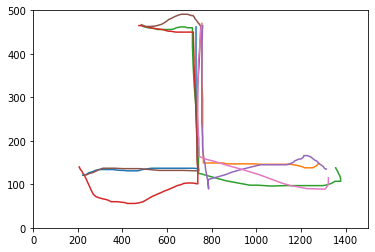

In [727]:
trials.plot()

## todo

1. create update function in maketrial function to make calling classes much easier
2. implement l1/l2 regression to find weights for each indicator
3. figure out what indicators we need and how to measure them
4. figure out actual functions for the indicators I have now - weighting of severity of variation